### Watershed 205 (work in progress)
##### The winning model made use of overfitting to make a 1 time-step prediction. However for longer prediction periods (e.g. one week), the model was very inaccurate. 
##### This model calculates snow pack, snow melt and includes these in the prediction. This model is still being worked on. 

In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copy training dataset to local drive. 
!cp /content/drive/MyDrive/EDAs/watershed_205.csv /content/

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow.keras.backend as K

# Function to reshape the input data for the LSTM model
def create_lstm_input(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Load the data
data = pd.read_csv('watershed_205.csv')

# Snowmelt equation
def snowmelt(temp_max, temp_min, pr):
    temp_threshold = 0.0  # Temperature in Celsius to consider for snow melting
    if temp_max <= temp_threshold:
        return 0
    else:
        melt_factor = 0.1  # You can calibrate this factor based on the domain knowledge
        melt = melt_factor * (temp_max - temp_threshold)
        return min(melt, pr)

# Apply the snowmelt equation to the dataset
data['snowmelt'] = data.apply(lambda row: snowmelt(row['tasmax'], row['tasmin'], row['pr']), axis=1)

# Calculate precipitation in conjunction with snowmelt. 
def calculate_snowpack_and_effective_precipitation(data):
    data['snow_pack'] = 0.0
    data['effective_precipitation'] = 0.0
    snow_pack = 0.0

    for i, row in data.iterrows():
        # Calculate snow pack and effective precipitation
        if row['tasmin'] <= 0 and row['tasmax'] <= 0:
            snow_pack += row['pr']
            effective_precipitation = 0.0
        else:
            snow_melt = row['pr'] * (row['tasmax'] - 0) / (row['tasmax'] - row['tasmin'])
            effective_precipitation = row['pr'] + snow_melt
            snow_pack = max(0, snow_pack - snow_melt)

        # Update the snow pack and effective precipitation columns
        data.at[i, 'snow_pack'] = snow_pack
        data.at[i, 'effective_precipitation'] = effective_precipitation

    return data

# Calculate snow pack and effective precipitation
data = calculate_snowpack_and_effective_precipitation(data)

# Create new columns with precipitation values from the previous week
for i in range(1, 8):
    data[f'pr_lag_{i}'] = data['pr'].shift(i)

# Create new columns with discharge values from the previous week
for i in range(1, 8):
    data[f'discharge_lag_{i}'] = data['discharge'].shift(i)

# Create new columns with snowmelt values from the previous week
for i in range(1, 8):
    data[f'snowmelt_lag_{i}'] = data['snowmelt'].shift(i)
  

# Drop rows with missing values created by the shift operations
data.dropna(inplace=True)

# Split the dataset into features and target variable
X = data.drop('discharge', axis=1)
y = data['discharge']


"""# Split the dataset into features and target variable
X = data[['pr', 'tasmax', 'tasmin', 'snowmelt']]
y = data['discharge']"""

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for the LSTM model
time_steps = 400  # You can adjust this value 
X_train_lstm, y_train_lstm = create_lstm_input(pd.DataFrame(X_train_scaled), y_train, time_steps)
X_test_lstm, y_test_lstm = create_lstm_input(pd.DataFrame(X_test_scaled), y_test, time_steps)

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# Build custom loss function
def custom_loss(y_true, y_pred):
    # Set the threshold for extreme discharge values
    threshold = 4 * K.std(y_true)

    # Calculate the absolute difference between true and predicted values
    error = K.abs(y_true - y_pred)

    # Create a boolean mask for the extreme discharge values
    extreme_values_mask = K.greater(y_true, threshold)

    # Calculate the penalty for extreme discharge values
    extreme_penalty = 100  # Adjust this value based on the desired level of penalty
    extreme_error = error * extreme_penalty * K.cast(extreme_values_mask, 'float32')

    # Calculate the penalty for other discharge values
    normal_error = error * K.cast(K.not_equal(extreme_values_mask, True), 'float32')

    # Combine the errors and return the mean
    return K.mean(normal_error + extreme_error)

# Compile the model using the custom loss function
model.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])

"""# Train the model using the custom loss function
model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_split=0.1)



# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])"""

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, mae = model.evaluate(X_test_lstm, y_test_lstm)

print(f"Mean Absolute Error: {mae}")

# Make predictions
predictions_lstm = model.predict(X_test_lstm).flatten()


Epoch 1/50
63/63 [==============================] - 79s 804ms/step - loss: 82.1559 - mae: 6.2706 - val_loss: 53.3842 - val_mae: 8.5168
Epoch 2/50
63/63 [==============================] - 42s 665ms/step - loss: 74.6058 - mae: 9.9283 - val_loss: 48.6291 - val_mae: 11.2807
Epoch 3/50
63/63 [==============================] - 43s 677ms/step - loss: 70.7219 - mae: 12.6349 - val_loss: 46.8223 - val_mae: 14.0806
Epoch 4/50
63/63 [==============================] - 41s 648ms/step - loss: 59.1649 - mae: 14.8483 - val_loss: 47.5472 - val_mae: 15.5102
Epoch 5/50
63/63 [==============================] - 42s 658ms/step - loss: 53.7864 - mae: 16.0032 - val_loss: 48.0672 - val_mae: 16.5235
Epoch 6/50
63/63 [==============================] - 42s 669ms/step - loss: 61.8706 - mae: 16.6309 - val_loss: 48.5991 - val_mae: 17.5385
Epoch 7/50
63/63 [==============================] - 42s 669ms/step - loss: 53.3238 - mae: 17.5602 - val_loss: 48.7257 - val_mae: 17.7790
Epoch 8/50
63/63 [==========================

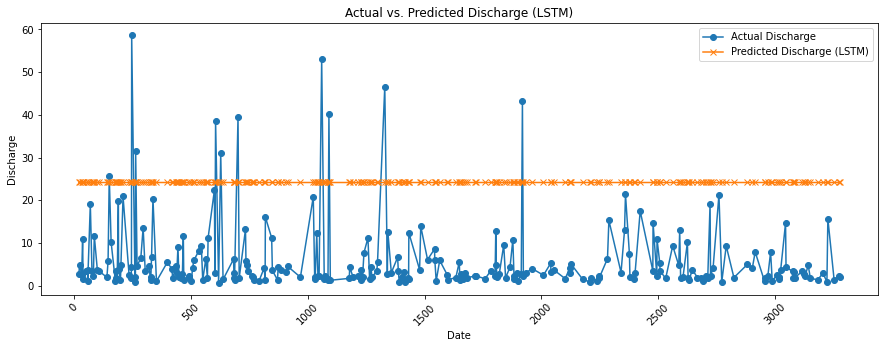

In [16]:
# Get the dates from the index
dates = data.index

# Split the dates into training and testing sets
_, dates_test = train_test_split(dates, test_size=0.2, random_state=42)

# Convert the test set dates into a DataFrame and reset the index
dates_test = pd.DataFrame(dates_test, columns=['date']).reset_index(drop=True)

# Since the actual and predicted discharge values will have different lengths after applying 'create_lstm_input',
# we need to match the 'dates_test' length to 'y_test_lstm'
dates_test = dates_test.iloc[:len(y_test_lstm)]

# Create a DataFrame with the actual and predicted discharge values
results = pd.DataFrame({'date': dates_test['date'], 'actual': y_test_lstm, 'predicted': predictions_lstm})

# Sort the results by date
results = results.sort_values(by='date')

# Plot the line graph
plt.figure(figsize=(15, 5))
plt.plot(results['date'], results['actual'], label='Actual Discharge', linestyle='-', marker='o')
plt.plot(results['date'], results['predicted'], label='Predicted Discharge (LSTM)', linestyle='-', marker='x')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Actual vs. Predicted Discharge (LSTM)')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()
